In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_group: "02_28_24_Shapes_Setting3"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_baseline_rows: True 
    load_pixel_meters: False 
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    load_groupavg_metrics: False
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/storage/vbutoi/projects/ESE/ese/experiment/analysis/analyze_inf.py:154: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  inference_df = pd.concat([inference_df, log_image_df])


Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 18000 -> 18000 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                        log_set                                              
/storage/vbutoi/scratch/ESE/inference/02_28_24_Shapes_Setting3/Shapes_Ensemble_FT_CE            20240228_174355-NS3Q-3930b86fec1520ef7dd4759d64c3f90c    640
                                                                                                20240228_174359-R2J0-c0f9d97e5be2a91c906c087ba914b62e    640
/storage/vbutoi/scratch/ESE/inference/02_28_24_Shapes_Setting3/Shapes_Ensemble_FT_Dice          20240228_174402-BH5D-88ef7c7445ad796424cc6e6a1d4903a0    640
                                                                                                20240228_174405-9B7V-4e563e905785e24902cdd8426774eb1a    640
/storage/vbutoi/scratch/ESE/inference/02_28_24_Shapes_Setting3/Shapes_Ensemble_Nect

In [4]:
image_info_df['calibrator'].unique()

array(['Uncalibrated', 'FT_Dice', 'TempScaling', 'FT_CE', 'NectarScaling'],
      dtype=object)

## We are going to remove the case where there are very few pixels, cause unrealistic outliers.

In [5]:
# Sort the image_info_df by method name, so everything appears nicely
image_info_df = image_info_df.sort_values(by=['method_name', 'calibrator'])
# Make sure that the model_class 'Uncalibrated' is first
image_info_df['calibrator'] = image_info_df['calibrator'].astype('category')
image_info_df['calibrator'] = image_info_df['calibrator'].cat.reorder_categories([
    'Uncalibrated',
    'FT_CE',
    'FT_Dice',
    'TempScaling', 
    'NectarScaling',
])

In [6]:
image_info_df['method_name'].unique()

array(['Average UNet', 'Ensemble (mean, probs)',
       'Ensemble (product, probs)', 'UNet (seed=40)', 'UNet (seed=41)',
       'UNet (seed=42)', 'UNet (seed=43)'], dtype=object)

In [7]:
# Select only the rows corresponding to group methods
image_info_df = image_info_df[image_info_df['model_type'] == 'group']

image_info_df['method_name'] = image_info_df['method_name'].astype('category')
image_info_df['method_name'] = image_info_df['method_name'].cat.reorder_categories([
    'Average UNet',
    'Ensemble (mean, probs)', 
    'Ensemble (product, probs)', 
    # 'UNet (seed=40)', 
    # 'UNet (seed=41)', 
    # 'UNet (seed=42)', 
    # 'UNet (seed=43)', 
])

image_info_df['split'] = image_info_df['split'].astype('category')
image_info_df['split'] = image_info_df['split'].cat.reorder_categories([
    'cal'
])

# Let's looks at the calibration scores of our models.

## ECE Metrics

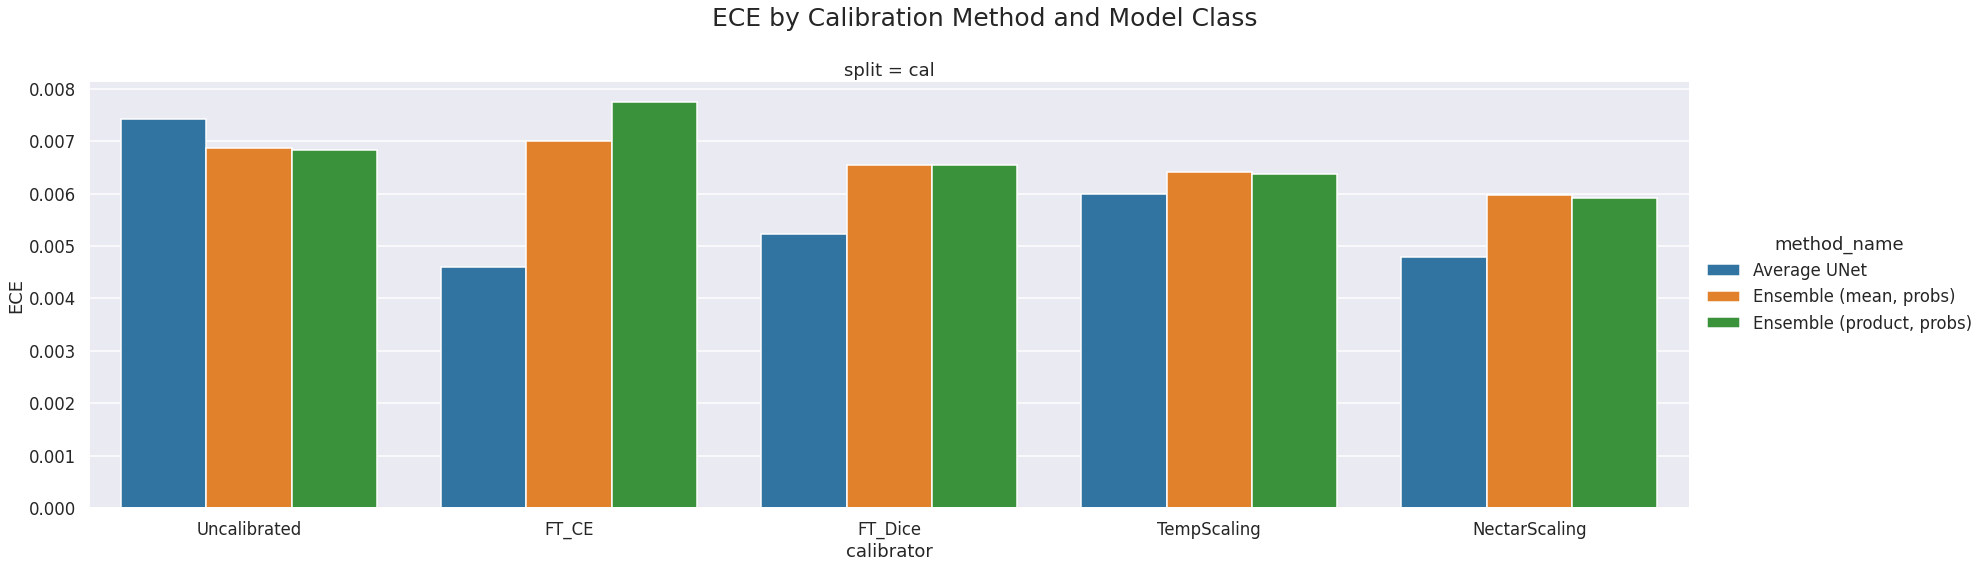

In [8]:
g = sns.catplot(
    data=image_info_df,
    x="calibrator",
    y="ECE",
    hue="method_name",
    row="split",
    kind="bar",
    height=8,
    aspect=3,
    sharex=False
)
# Set column spacingj
# Set the title of the plot
# g.set(ylim=(0.0, 0.001))
g.fig.suptitle("ECE by Calibration Method and Model Class", fontsize=25)
# Change the title fontsize
# Move the title slightly up
g.fig.subplots_adjust(top=0.85)

In [9]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="CW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [10]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-CW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("Uniform-CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [11]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Edge-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.05))
# g.fig.suptitle("Edge ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [12]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="ECW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.004))
# g.fig.suptitle("Edge CW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [13]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-ECW-ECE",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.05))
# g.fig.suptitle("Uniform ECW-ECE by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

## ELM Metrics

In [14]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [15]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Edge-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.001))
# g.fig.suptitle("Edge-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [16]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.3))
# g.fig.suptitle("Uniform-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

In [17]:
# g = sns.catplot(
#     data=image_info_df,
#     x="calibrator",
#     y="Uniform-Edge-ELM",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3,
#     sharex=False
# )
# # Set column spacing
# # # Set the y-axis limits
# # g.set(ylim=(0.0, 0.3))
# g.fig.suptitle("Uniform-Edge-ELM by Calibration Method and Model Class")
# # Move the title slightly up
# g.fig.subplots_adjust(top=0.9)

## Now we can look at the quality averages themselves, first looking slice-wise.

In [18]:
image_info_df["image_metric"].unique()

array(['BoundaryIOU', 'Dice', 'HD95', 'Hard_Ens_VAR', 'Image_CW-ECE',
       'Image_ECE', 'Image_ECW-ECE', 'Image_ELM', 'Image_Edge-ECE',
       'Image_Edge-ELM', 'Image_Uniform-CW-ECE', 'Image_Uniform-ECW-ECE',
       'Image_Uniform-ELM', 'Image_Uniform-Edge-ELM', 'Soft_Ens_VAR',
       'Dice Loss'], dtype=object)

In [19]:
table_df = image_info_df.groupby(["method_name", "calibrator", "image_metric", "ensemble"])['metric_score'].mean().reset_index()
dice_table = image_info_df[image_info_df["image_metric"] == "Dice"]
dice_loss_table = image_info_df[image_info_df["image_metric"] == "Dice Loss"]
hd95_table = image_info_df[image_info_df["image_metric"] == "HD95"]
boundaryiou_table = image_info_df[image_info_df["image_metric"] == "BoundaryIOU"]
# Variance dfs
soft_var_table = image_info_df[image_info_df["image_metric"] == "Soft_Ens_VAR"]
hard_var_table = image_info_df[image_info_df["image_metric"] == "Hard_Ens_VAR"]

In [20]:
# Load the pickled df corresponding to the upper-bound of the uncalibrated UNets
from ese.experiment.analysis.analysis_utils.inference_utils import load_upperbound_df 

# Fill the column corresponding to slice_idx with string 'None'
upperbound_df = load_upperbound_df(results_cfg['log'])

Error loading upperbound df: [Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/02_28_24_Shapes_Setting3/ensemble_upper_bounds/'


In [21]:
if upperbound_df is not None:
    dice_ub_df = upperbound_df[upperbound_df["image_metric"] == "Dice"]
    dice_loss_ub_df = upperbound_df[upperbound_df["image_metric"] == "Dice Loss"]
    hd95_ub_df = upperbound_df[upperbound_df["image_metric"] == "HD95"]
    boundaryiou_df = upperbound_df[upperbound_df["image_metric"] == "BoundaryIOU"]
    # De Nan the dice_ub_df
    dice_ub_df = dice_ub_df[dice_ub_df['metric_score'].notna()]
    dice_loss_ub_df = dice_loss_ub_df[dice_loss_ub_df['metric_score'].notna()]
    hd95_ub_df = hd95_ub_df[hd95_ub_df['metric_score'].notna()]
    boundaryiou_df = boundaryiou_df[boundaryiou_df['metric_score'].notna()]

In [22]:
upperbound_df

In [23]:
from ese.experiment.analysis.analysis_utils.plot_utils import plot_upperbound_line

num_calibrators = len(image_info_df['calibrator'].unique())

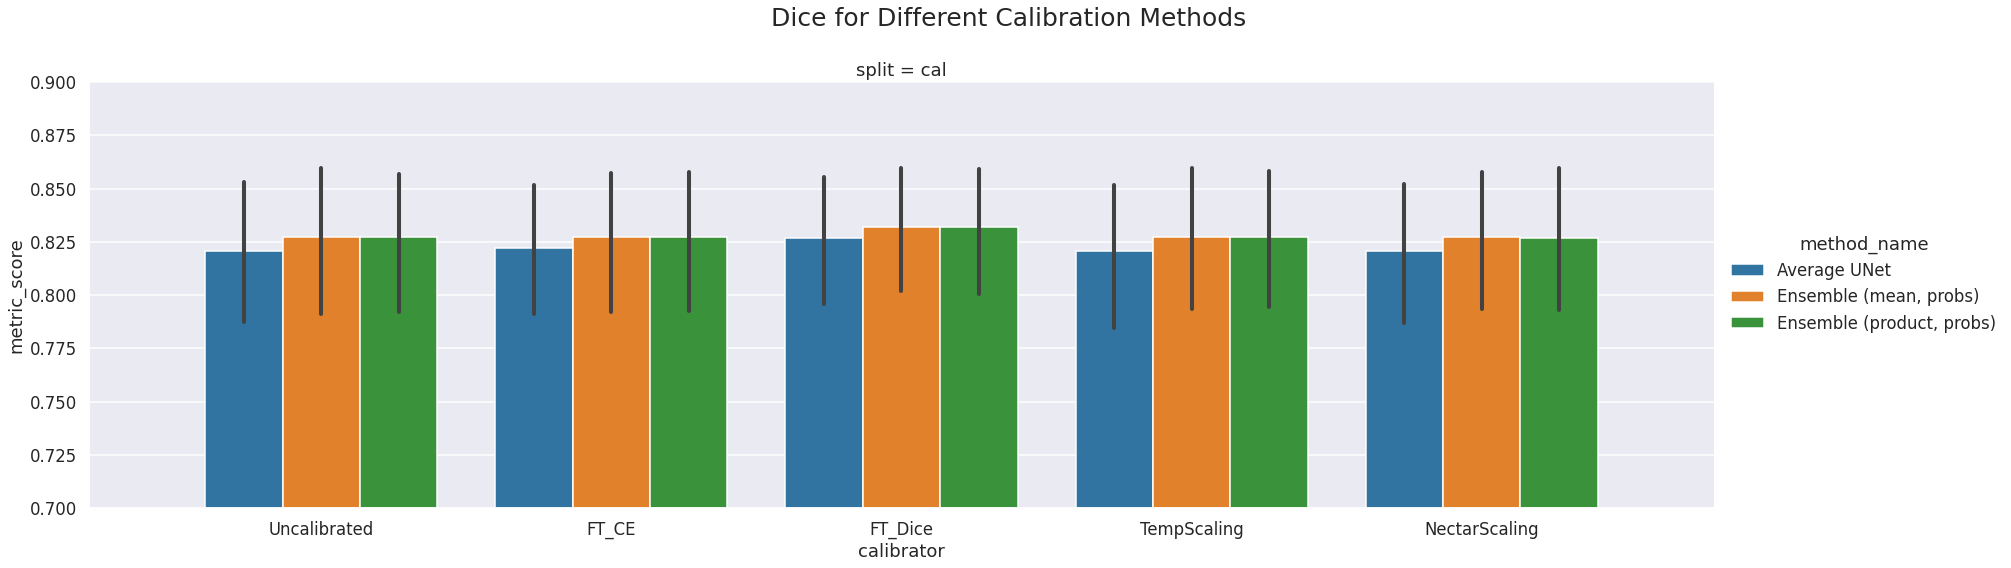

In [24]:
g = sns.catplot(
    data=dice_table,
    x="calibrator",
    y="metric_score",
    hue="method_name",
    row="split",
    kind="bar",
    height=8,
    aspect=3,
    sharex=False
)
if upperbound_df is not None:
    plot_upperbound_line(
        graph=g, 
        plot_df=dice_ub_df, 
        y="metric_score", 
        num_calibrators=num_calibrators, 
        col="split"
    )
# Set the title of the bar plot
g.fig.suptitle("Dice for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
g.set(ylim=(0.7, 0.9))

In [25]:
# g = sns.catplot(
#     data=hd95_table,
#     x="calibrator",
#     y="metric_score",
#     hue="method_name",
#     row="split",
#     kind="bar",
#     height=8,
#     aspect=3
# )
# if upperbound_df is not None:
#     plot_upperbound_line(
#         graph=g, 
#         plot_df=hd95_ub_df, 
#         y="metric_score", 
#         num_calibrators=num_calibrators, 
#         col="split"
#     )
# # Set the title of the bar plot
# g.fig.suptitle("Hausdorff Distance for Different Calibration Methods")
# # Give the title a bit of spacing from the plot
# g.fig.subplots_adjust(top=0.90)
# # Set the y axis to be between 0.5 and 1.0
# calibrators_width = num_calibrators - 1
# g.set(xlim=(-0.8, calibrators_width + 0.8))
# # g.set(ylim=(3.0, 12))

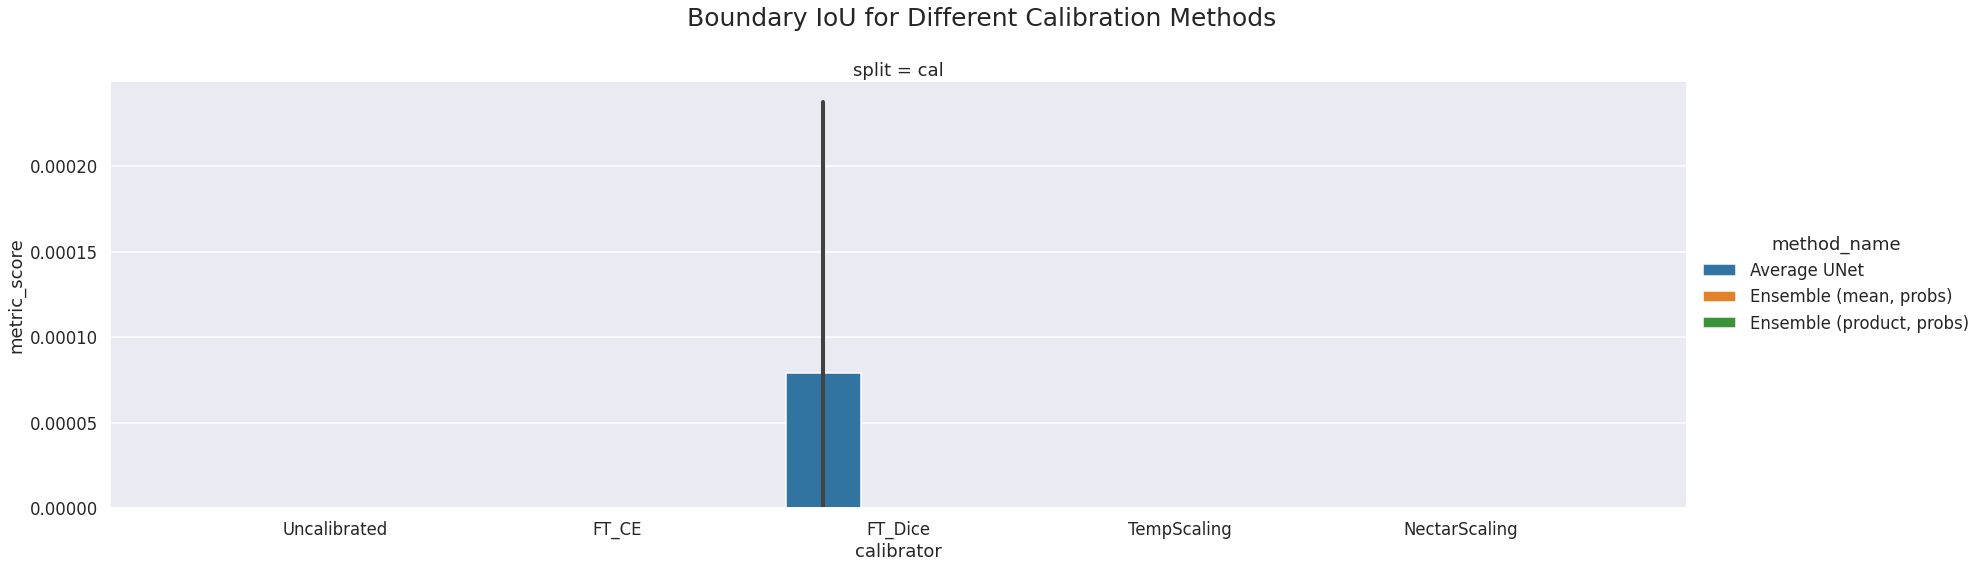

In [26]:
g = sns.catplot(
    data=boundaryiou_table,
    x="calibrator",
    y="metric_score",
    hue="method_name",
    row="split",
    kind="bar",
    height=8,
    aspect=3,
    sharex=False
)
if upperbound_df is not None:
    plot_upperbound_line(
        graph=g, 
        plot_df=boundaryiou_df, 
        y="metric_score", 
        num_calibrators=num_calibrators, 
        col="split"
    )
# Set the title of the bar plot
g.fig.suptitle("Boundary IoU for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
# g.set(ylim=(0.1, 0.3))

In [27]:
soft_var_table = soft_var_table[soft_var_table['method_name'] != "Average UNet"]
hard_var_table = hard_var_table[hard_var_table['method_name'] != "Average UNet"]

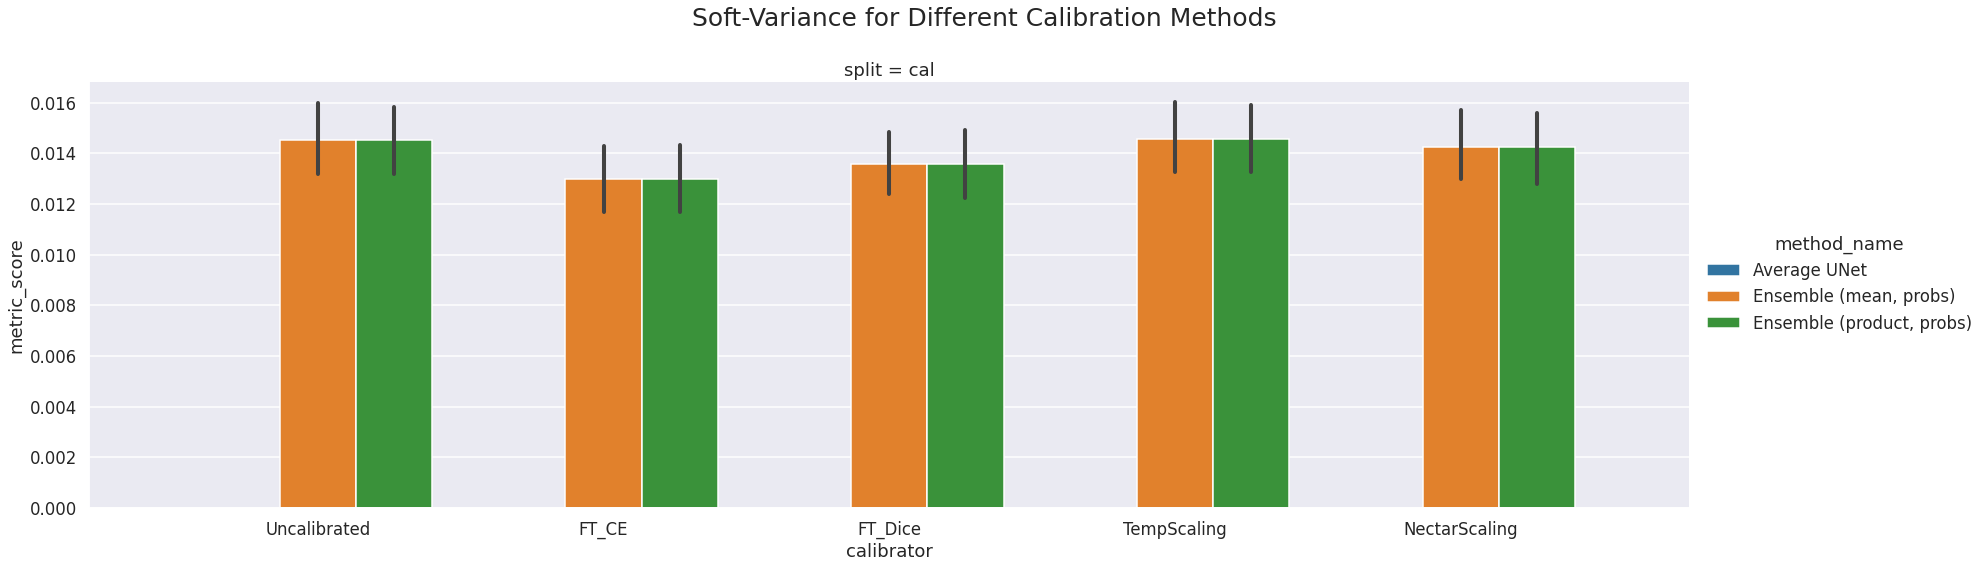

In [28]:
g = sns.catplot(
    data=soft_var_table,
    x="calibrator",
    y="metric_score",
    hue="method_name",
    row="split",
    kind="bar",
    height=8,
    aspect=3,
    sharex=False
)
# Set the title of the bar plot
g.fig.suptitle("Soft-Variance for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
# g.set(ylim=(0.8, 1.0))

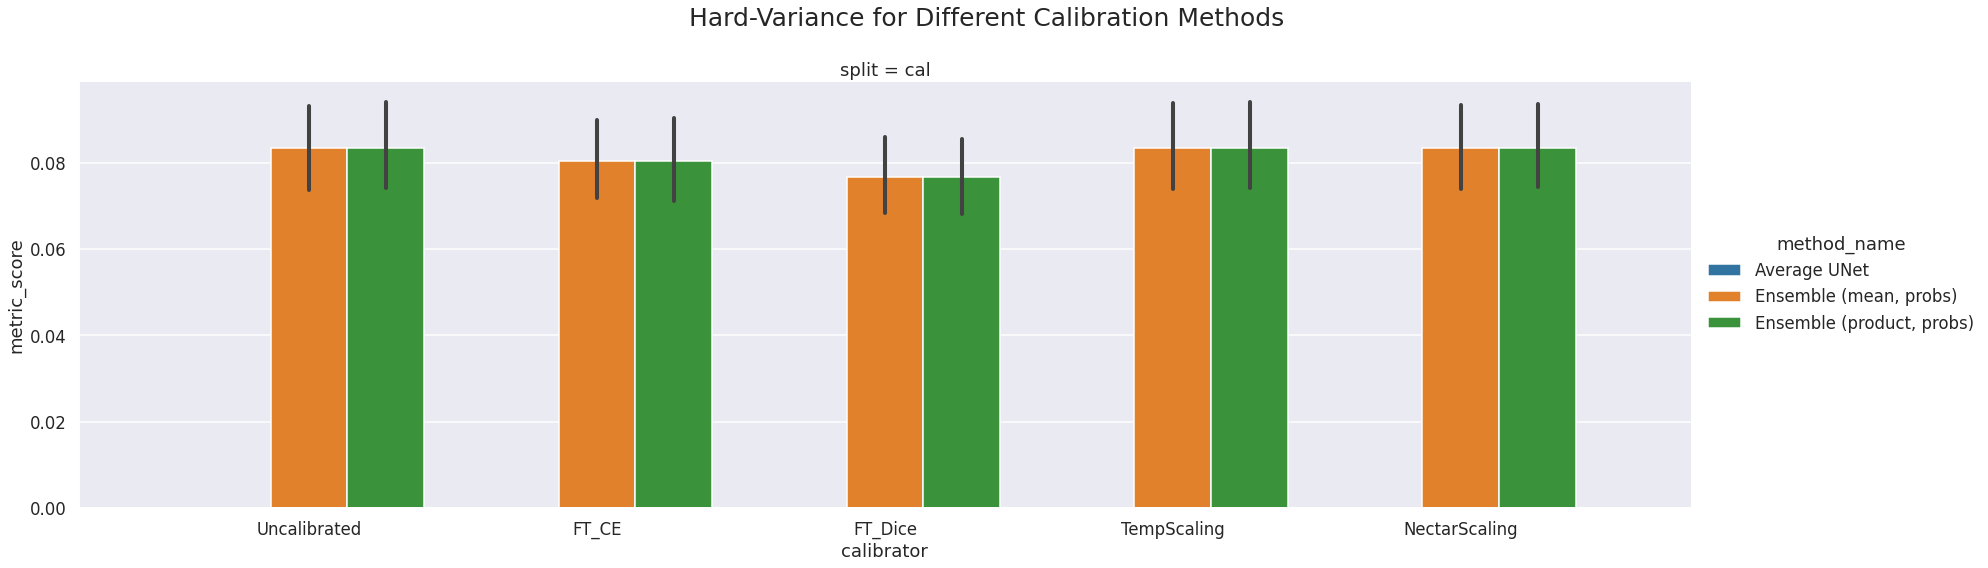

In [29]:
g = sns.catplot(
    data=hard_var_table,
    x="calibrator",
    y="metric_score",
    hue="method_name",
    row="split",
    kind="bar",
    height=8,
    aspect=3,
    sharex=False
)
# Set the title of the bar plot
g.fig.suptitle("Hard-Variance for Different Calibration Methods", fontsize=25)
# Give the title a bit of spacing from the plot
g.fig.subplots_adjust(top=0.85)
# Set the y axis to be between 0.5 and 1.0
calibrators_width = num_calibrators - 1
g.set(xlim=(-0.8, calibrators_width + 0.8))
# g.set(ylim=(0.8, 1.0))